In [62]:
import os
from PIL import Image, ImageEnhance
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import random
import numpy as np
from glob import glob
import os.path as osp
from pathlib import Path
from segment_anything.utils.transforms import ResizeLongestSide

# several data augumentation strategies
def cv_random_flip(imgs, label):
    # left right flip
    flip_flag = random.randint(0, 1)
    if flip_flag == 1:
        for i in range(len(imgs)):
            imgs[i] = imgs[i].transpose(Image.FLIP_LEFT_RIGHT)
            label[i] = label[i].transpose(Image.FLIP_LEFT_RIGHT)
    return imgs, label


def randomCrop(imgs, label):
    border = 30
    image_width = imgs[0].size[0]
    image_height = imgs[0].size[1]
    crop_win_width = np.random.randint(image_width - border, image_width)
    crop_win_height = np.random.randint(image_height - border, image_height)
    random_region = (
        (image_width - crop_win_width) >> 1,
        (image_height - crop_win_height) >> 1,
        (image_width + crop_win_width) >> 1,
        (image_height + crop_win_height) >> 1,
    )

    for i in range(len(imgs)):
        imgs[i] = imgs[i].crop(random_region)
        label[i] = label[i].crop(random_region)
    return imgs, label


def randomRotation(imgs, label):
    mode = Image.BICUBIC
    if random.random() > 0.8:
        random_angle = np.random.randint(-15, 15)
        for i in range(len(imgs)):
            imgs[i] = imgs[i].rotate(random_angle, mode)
            label[i] = label[i].rotate(random_angle, mode)
    return imgs, label


def colorEnhance(imgs):
    for i in range(len(imgs)):
        bright_intensity = random.randint(5, 15) / 10.0
        imgs[i] = ImageEnhance.Brightness(imgs[i]).enhance(bright_intensity)
        contrast_intensity = random.randint(5, 15) / 10.0
        imgs[i] = ImageEnhance.Contrast(imgs[i]).enhance(contrast_intensity)
        color_intensity = random.randint(0, 20) / 10.0
        imgs[i] = ImageEnhance.Color(imgs[i]).enhance(color_intensity)
        sharp_intensity = random.randint(0, 30) / 10.0
        imgs[i] = ImageEnhance.Sharpness(imgs[i]).enhance(sharp_intensity)
    return imgs


def randomPeper(img_list):
    output_list = []
    for img in img_list:
        img = np.array(img)
        noiseNum = int(0.0015 * img.shape[0] * img.shape[1])

        for i in range(noiseNum):
            randX = random.randint(0, img.shape[0] - 1)
            randY = random.randint(0, img.shape[1] - 1)

            if random.randint(0, 1) == 0:
                img[randX, randY] = 0
            else:
                img[randX, randY] = 255
        output_list.append(Image.fromarray(img))
    return output_list


class VideoDataset(data.Dataset):
    def __init__(
        self,
        dataset="MoCA-Mask/MoCA_Video",
        seq_len=4,
        trainsize=1024,
        split="TrainDataset_per_sq"
    ):
        self.seq_len = seq_len
        self.trainsize = trainsize
        self.transform = ResizeLongestSide(trainsize)
        self.image_list = []
        self.gt_list = []
        self.extra_info = []

        root = Path(dataset)
        img_format = "*.jpg"
        data_root = osp.join(root, split)

        for scene in os.listdir(osp.join(data_root)):
            if split == "MoCA-Video-Train":
                images = sorted(glob(osp.join(data_root, scene, "Frame", img_format)))
            elif split == "TrainDataset_per_sq":
                images = sorted(glob(osp.join(data_root, scene, "Imgs", img_format)))
            gt_list = sorted(glob(osp.join(data_root, scene, "GT", "*.png")))
            # pdb.set_trace()

            for i in range(len(images) - seq_len):
                self.extra_info += [(scene, i)]  # scene and frame_id
                self.gt_list += [[gt_list[i + j] for j in range(seq_len)]]
                self.image_list += [[images[i + j] for j in range(seq_len)]]
        
        self.gt_transform = transforms.Compose([
            transforms.ToTensor()
            ])

    def __getitem__(self, index):
        imgs = []
        names = []
        all_gt = []
        index = index % len(self.image_list)

        for i in range(len(self.image_list[index])):
            imgs += [self.rgb_loader(self.image_list[index][i])]
            names += [self.image_list[index][i].split("/")[-1]]
            all_gt += [self.binary_loader(self.gt_list[index][i])]

        # print(names)
        scene = self.image_list[index][0].split("/")[-3]

        imgs, all_gt = cv_random_flip(imgs, all_gt)
        # imgs, all_gt = randomCrop(imgs, all_gt)
        imgs, all_gt = randomRotation(imgs, all_gt)
        imgs = colorEnhance(imgs)
        all_gt = randomPeper(all_gt)

        for i in range(len(imgs)):
            imgs[i] = torch.as_tensor(self.transform.apply_image(np.array(imgs[i], dtype=np.uint8))).permute(2, 0, 1)
            all_gt[i] = self.gt_transform(all_gt[i])[0]
        # all_gt, gt = all_gt[:-1], all_gt[-1]

        # NOTE: imgs will have current_frame and prev_frame. In case, we plan to use only the prev_frames as an input for the propagation module, change imgs -> imgs[-1] in which case image -> (3, H, W)
        return {"image": imgs, "gt_masks": all_gt, "original_size": tuple(imgs[0][0].shape)} # image -> list((3, H, W)), gt_masks -> list((H, W)), original_size: (H, W)

    def rgb_loader(self, path):
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

    def binary_loader(self, path):
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("L")

    def __len__(self):
        return len(self.image_list)

def collate_fn(batch):
    return batch

# dataloader for training
def get_loader(
    dataset = "MoCA-Mask/MoCA_Video",
    batchsize = 1,
    seq_len = 4,
    trainsize = 1024,
    train_split = "TrainDataset_per_sq",
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn
):
    dataset = VideoDataset(dataset, seq_len, trainsize, split=train_split)
    data_loader = data.DataLoader(
        dataset=dataset,
        batch_size=batchsize,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )
    return data_loader

In [63]:
a = get_loader(dataset="../MoCA-Mask/MoCA_Video/")

In [64]:
b = next(iter(a))

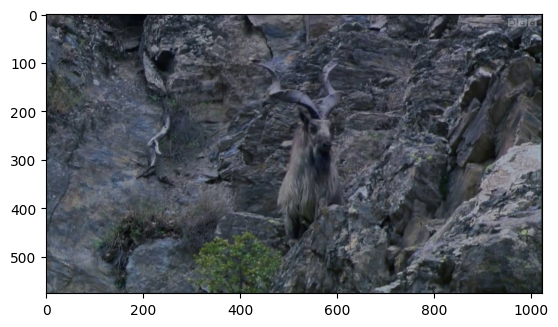

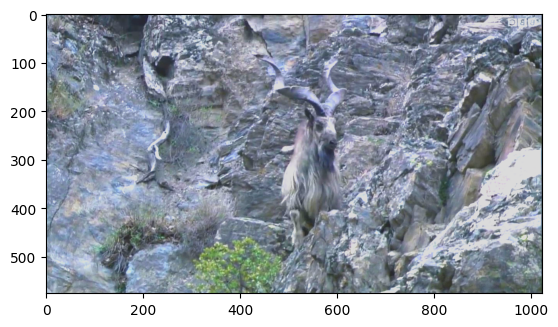

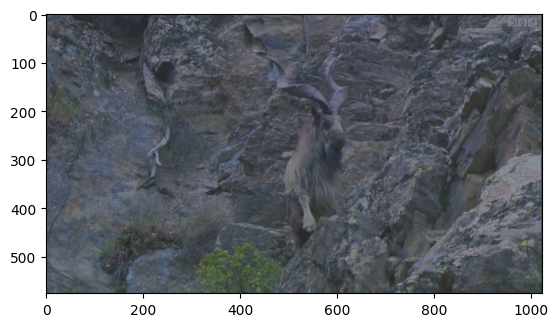

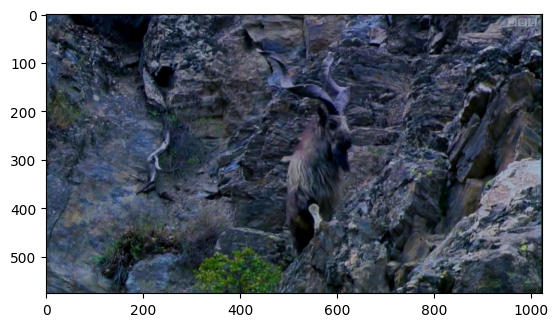

In [65]:
import matplotlib.pyplot as plt
b = next(iter(a))
abc = b[0]
l = len(abc['image'] )
for j in range(l):
    plt.figure()
    plt.imshow(abc['image'][j].permute(1, 2, 0))
    

In [105]:
len(b[1])

10

In [106]:
import matplotlib.pyplot as plt

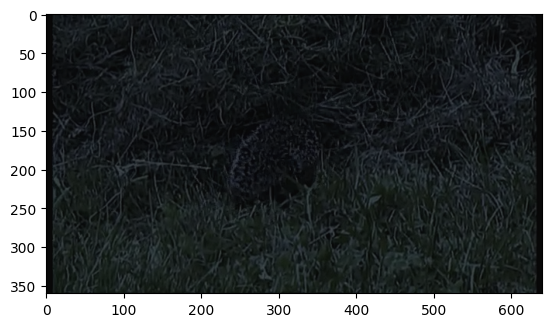

In [107]:
plt.imshow(b[0][0][0].permute(1, 2, 0))

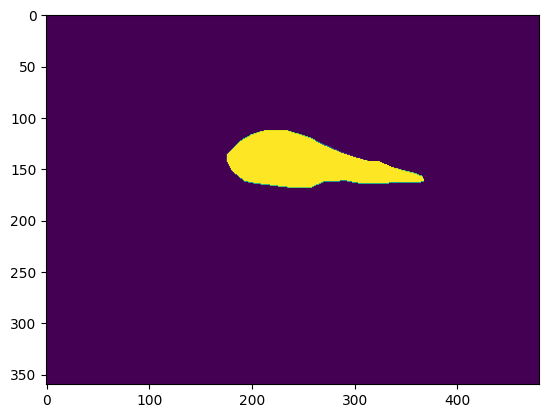

In [99]:
plt.imshow(b[1][0][0][0])


In [43]:
a.dataset.gt_list

[['MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00000.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00005.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00010.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00015.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00020.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00025.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00030.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00035.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00040.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00045.png'],
 ['MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00005.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00010.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00015.png',
  'MoCA-Mask/MoCA_Video/TrainDataset_per_sq/flatfish_1/GT/00020.png',
  'MoCA-Mask/MoCA_V

In [21]:
from PIL import Image
import cv2

a = Image.open("notebooks/images/dog.jpg")
b = cv2.imread("notebooks/images/dog.jpg")
image = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
(image == a).sum()

1281600

534.0